# IMAT data vertical settings: peak fitting
## In this notebook I start from the spectra saved in the Imat_data_verticalSettings notebook, and apply peak fitting in selected peaks. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
#%matplotlib inline
%matplotlib notebook
import scipy.signal
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
from scipy.stats import binned_statistic
from scipy.signal import resample
from scipy.signal import argrelextrema

import AdvancedBraggEdgeFitting
import TOF_routines
from TOF_routines import binning
from TOF_routines import tof2l
from TOF_routines import l2tof
from TOF_routines import find_nearest

In [2]:
# here now I put the number obtained from the flight-path calibration
t0 =  0.0002466
L = 56.065
lambda0 = 0.017
dL = 0

In [3]:
# Load of computed spectra for the selected ROIs
stress_304 = np.loadtxt('spectrum_stress_304.txt')
ob_304 = np.loadtxt('spectrum_ob_stress_304.txt')
stress_316 = np.loadtxt('spectrum_stress_316.txt')
ob_316 = np.loadtxt('spectrum_ob_stress_316.txt')

# Load TOF
myTOF = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/03_VerticalSetting_3hruns/Flat1_Corrected/IMAT00010433_VerticalSetting_2hruns_000_Spectra.txt', usecols=0)

In [4]:
# Load some theoretical values
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)
mygamma = np.genfromtxt('gamma.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)

dhkl_gammaFe = np.genfromtxt('gammaFe_hkl', usecols=4)
h_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=0)
k_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=1)
l_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=2)

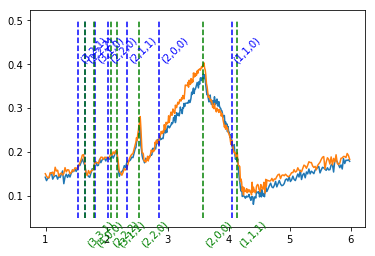

In [5]:
# Angle by angle comparison, now normalization by the last part
stress304_spectrum_norm=(stress_304[0][:]/ob_304[0][:])
last_part_304 = np.mean(stress304_spectrum_norm[1500:2000])        
stress304_spectrum_binned = TOF_routines.binning(stress304_spectrum_norm/1, 350)
stress316_spectrum_norm=(stress_316[0][:]/ob_316[0][:])
last_part_316 = np.mean(stress316_spectrum_norm[1500:2000])        
stress316_spectrum_binned = TOF_routines.binning(stress316_spectrum_norm/1, 350)
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress304_spectrum_binned))
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress316_spectrum_binned))

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([0.05,0.5]), '--b',label=r'$\alpha$ Fe - Martensite')
    else:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([0.05,0.5]), '--b')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],0.45, mytext, rotation=45, color='b')

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([0.05,0.5]), '--g', label=r'$\gamma$ Fe - Austenite')
    else:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([0.05,0.5]), '--g')                    

    mytext = '('+str((h_gammaFe[i]).astype(int))+','+str(k_gammaFe[i].astype(int))+','+str(l_gammaFe[i].astype(int))+')'
    plt.text(2*dhkl_gammaFe[i],0.03, mytext, rotation=45, color='g')

In [6]:
print(2*dhkl_gammaFe[:])

[4.142 3.588 2.536 2.164 2.07  1.794 1.646 1.604 1.464 1.38  1.38  1.268
 1.212 1.196 1.196 1.134 1.094 1.082 1.036 1.004 1.004 0.994 0.958 0.934
 0.934 0.896 0.876 0.87  0.87  0.846 0.846 0.828 0.828 0.822 0.802 0.788
 0.782 0.764 0.732 0.722 0.722 0.718 0.704 0.694 0.69  0.666 0.646 0.634
 0.624 0.616 0.598 0.592 0.56  0.518]


180
3.5864977700380014


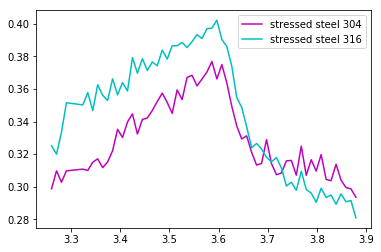

In [7]:
mylambda_binned = binning(tof2l(myTOF, lambda0,t0,L),350)
# print(np.where(3.58<mylambda_binned))
# print(np.where(3.59>mylambda_binned))
peak_position = find_nearest(mylambda_binned, 3.588)
print(peak_position)
print(mylambda_binned[180]) # this is my position to study the peak (2,0,0)

plt.plot(mylambda_binned[150:210], -1*np.log(stress304_spectrum_binned[150:210]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[150:210], -1*np.log(stress316_spectrum_binned[150:210]), label='stressed steel 316', color='c')
plt.legend(loc='upper right')

lambda_range = [3.3, 3.9]
myrange = np.array([find_nearest(mylambda_binned, lambda_range[0]), find_nearest(mylambda_binned, lambda_range[1])])



### known peak position for binned spectra: at position 180
### range used for peak fitting: 153-211, found with find_nearest

[153 211]
11
----- Stressed sample Steel 304 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 56
    # variables        = 7
    chi-square         = 5.4028e-04
    reduced chi-square = 1.1026e-05
    Akaike info crit   = -632.731518
    Bayesian info crit = -618.554057
[[Variables]]
    t0:     31.2872552 +/- 1.18569619 (3.79%) (init = 34.46952)
    sigma: -1.07470688 +/- 0.65578087 (61.02%) (init = -0.01352889)
    alpha: -2.23339970 +/- 1.23967352 (55.51%) (init = -15.76373)
    a1:     0.34133023 +/- 0.00269138 (0.79%) (init = 0.3406018)
    a2:     8.1171e-04 +/- 7.8450e-05 (9.66%) (init = 0.001860698)
    a5:    -0.00268684 +/- 1.7892e-04 (6.66%) (init = -0.00359817)
    a6:     12.4367238 +/- 1.06091843 (8.53%) (init = 10.32933)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.975
    C(a1, a6)       =  0.962
    C(t0, sigma

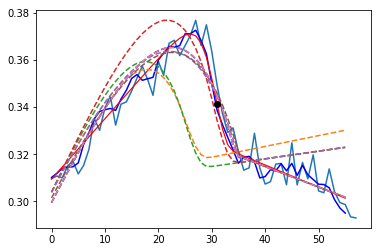

----- Stressed sample Steel 316 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 56
    # variables        = 7
    chi-square         = 3.0422e-04
    reduced chi-square = 6.2086e-06
    Akaike info crit   = -664.893891
    Bayesian info crit = -650.716429
[[Variables]]
    t0:     30.5195929 +/- 0.14183436 (0.46%) (init = 35.43069)
    sigma: -2.52137042 +/- 0.16706056 (6.63%) (init = -0.5267548)
    alpha: -0.43610490 +/- 8254.76845 (1892840.09%) (init = -16.86498)
    a1:     0.36473039 +/- 0.00202116 (0.55%) (init = 0.370256)
    a2:     8.2679e-05 +/- 6.8241e-05 (82.54%) (init = 0.001315838)
    a5:    -0.00347395 +/- 1.5633e-04 (4.50%) (init = -0.005049811)
    a6:     7.88570388 +/- 1.08560125 (13.77%) (init = 8.60403)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.959
    C(a5, a6)       = -0.948
    C(a1, a5)       = -0

/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: invalid value encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


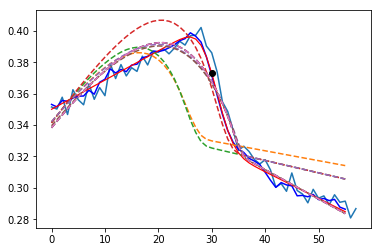

----- Stressed sample Steel 304 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 56
    # variables        = 7
    chi-square         = 8.0060e-04
    reduced chi-square = 1.6339e-05
    Akaike info crit   = -610.707926
    Bayesian info crit = -596.530464
[[Variables]]
    t0:     29.6279738 (init = 34.03858)
    sigma: -1.95109238 (init = -0.0003855533)
    alpha: -0.20843218 (init = -13.84558)
    a1:     0.68734406 (init = 0.6884516)
    a2:     8.0029e-04 (init = 0.001764385)
    a5:    -0.00240284 (init = -0.003379968)
    a6:     10.5488020 (init = 9.345233)



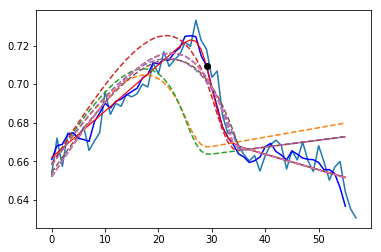

----- Stressed sample Steel 316 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 56
    # variables        = 7
    chi-square         = 7.1051e-04
    reduced chi-square = 1.4500e-05
    Akaike info crit   = -617.393050
    Bayesian info crit = -603.215588
[[Variables]]
    t0:     30.5399706 +/- 0.21024667 (0.69%) (init = 35.5063)
    sigma: -2.40696453 +/- 0.27659618 (11.49%) (init = -0.09517274)
    alpha: -0.49217706 +/- 328.922304 (66830.08%) (init = -17.25582)
    a1:     0.70537319 +/- 0.00320396 (0.45%) (init = 0.7094318)
    a2:     1.5885e-04 +/- 9.8106e-05 (61.76%) (init = 0.001394974)
    a5:    -0.00315350 +/- 2.3569e-04 (7.47%) (init = -0.004625528)
    a6:     7.55866806 +/- 1.76866869 (23.40%) (init = 7.992448)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.961
    C(a5, a6)       = -0.959
    C(a1, a5)       = -

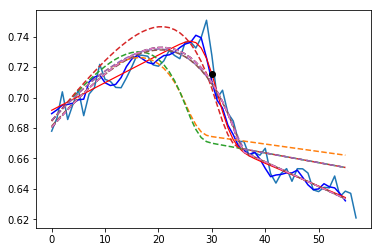

----- Stressed sample Steel 304 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 14
    # data points      = 56
    # variables        = 7
    chi-square         = 7.9125e-04
    reduced chi-square = 1.6148e-05
    Akaike info crit   = -611.365920
    Bayesian info crit = -597.188459
[[Variables]]
    t0:     28.8335577 +/- 0.68906421 (2.39%) (init = 33.18743)
    sigma: -1.72047156 +/- 0.70493935 (40.97%) (init = -0.206342)
    alpha: -0.92291751 +/- 0.79344419 (85.97%) (init = -12.88293)
    a1:     0.55960975 +/- 0.00279085 (0.50%) (init = 0.5584586)
    a2:     6.5412e-04 +/- 8.6875e-05 (13.28%) (init = 0.001494171)
    a5:    -0.00271262 +/- 2.0452e-04 (7.54%) (init = -0.003361724)
    a6:     14.0576580 +/- 1.20798391 (8.59%) (init = 11.66587)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.951
    C(a1, a5)       = -0.941
    C(a5, a6)       = -0.892

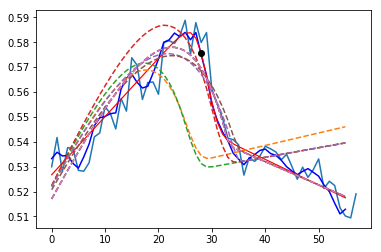

----- Stressed sample Steel 316 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 56
    # variables        = 7
    chi-square         = 5.8414e-04
    reduced chi-square = 1.1921e-05
    Akaike info crit   = -628.360225
    Bayesian info crit = -614.182763
[[Variables]]
    t0:     30.2349664 (init = 34.43823)
    sigma: -1.35000728 (init = -0.07638638)
    alpha: -0.13598220 (init = -14.74973)
    a1:     0.58349872 (init = 0.5849673)
    a2:     2.8023e-04 (init = 0.001469022)
    a5:    -0.00288710 (init = -0.004104781)
    a6:     8.58758286 (init = 7.836779)



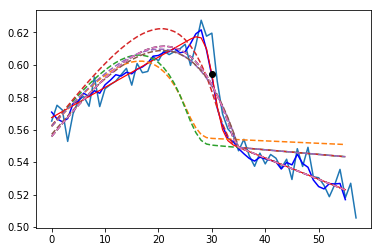

----- Stressed sample Steel 304 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 56
    # variables        = 7
    chi-square         = 3.0436e-04
    reduced chi-square = 6.2115e-06
    Akaike info crit   = -664.868137
    Bayesian info crit = -650.690675
[[Variables]]
    t0:     29.3140345 (init = 33.36127)
    sigma: -1.49812832 (init = -0.02438201)
    alpha: -0.10079993 (init = -13.01726)
    a1:     0.73100090 (init = 0.7299726)
    a2:     8.8643e-04 (init = 0.001838476)
    a5:    -0.00200740 (init = -0.00286816)
    a6:     9.70384795 (init = 8.072648)



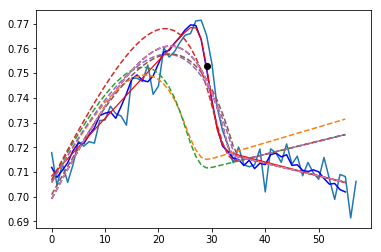

----- Stressed sample Steel 316 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 56
    # variables        = 7
    chi-square         = 7.2069e-04
    reduced chi-square = 1.4708e-05
    Akaike info crit   = -616.596828
    Bayesian info crit = -602.419366
[[Variables]]
    t0:     30.4296365 +/- 0.20972173 (0.69%) (init = 35)
    sigma: -2.13874624 +/- 0.30567865 (14.29%) (init = -7.921731e-09)
    alpha: -0.52276008 +/- 23.1061854 (4420.04%) (init = -15.71901)
    a1:     0.71745935 +/- 0.00449813 (0.63%) (init = 0.7226275)
    a2:     6.1011e-04 +/- 9.1732e-05 (15.04%) (init = 0.001651179)
    a5:    -0.00199277 +/- 2.2562e-04 (11.32%) (init = -0.003365258)
    a6:     3.27832524 +/- 2.40000055 (73.21%) (init = 5.873702)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.977
    C(a1, a6)       =  0.964
    C(a1, a5)       = -0.9

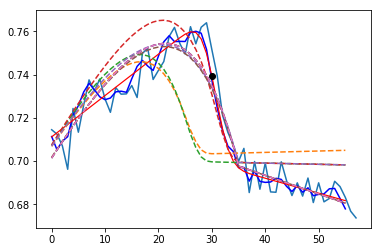

----- Stressed sample Steel 304 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 56
    # variables        = 7
    chi-square         = 3.0699e-04
    reduced chi-square = 6.2651e-06
    Akaike info crit   = -664.386527
    Bayesian info crit = -650.209065
[[Variables]]
    t0:     30.3751682 +/- 1.73466205 (5.71%) (init = 33.38169)
    sigma: -1.06851877 +/- 1.03445725 (96.81%) (init = -0.02088599)
    alpha: -1.21719082 +/- 1.13920405 (93.59%) (init = -12.87604)
    a1:     0.55001762 +/- 0.00214262 (0.39%) (init = 0.5516823)
    a2:     5.1810e-04 +/- 5.2342e-05 (10.10%) (init = 0.001195151)
    a5:    -0.00164260 +/- 1.2656e-04 (7.70%) (init = -0.002394064)
    a6:     9.16530811 +/- 1.35853134 (14.82%) (init = 8.658702)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.987
    C(t0, sigma)    =  0.981
    C(a1, a6)       =  0.

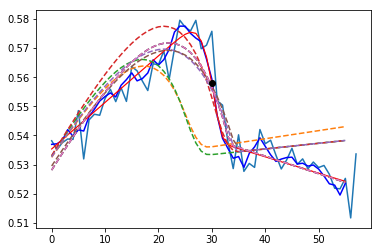

----- Stressed sample Steel 316 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 56
    # variables        = 7
    chi-square         = 2.9527e-04
    reduced chi-square = 6.0260e-06
    Akaike info crit   = -666.565794
    Bayesian info crit = -652.388332
[[Variables]]
    t0:     30.9666342 +/- 0.22972581 (0.74%) (init = 35.3255)
    sigma: -2.16596813 +/- 0.31419627 (14.51%) (init = -0.01899724)
    alpha: -0.84337879 +/- 0.78568831 (93.16%) (init = -16.45577)
    a1:     0.54239393 +/- 0.00327031 (0.60%) (init = 0.5483594)
    a2:     3.1584e-04 +/- 5.8887e-05 (18.64%) (init = 0.001181403)
    a5:    -0.00144040 +/- 1.5176e-04 (10.54%) (init = -0.002754264)
    a6:    -3.24641700 +/- 2.82899852 (87.14%) (init = 3.823822)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.989
    C(a1, a6)       =  0.939
    C(a1, a5)       = -0.

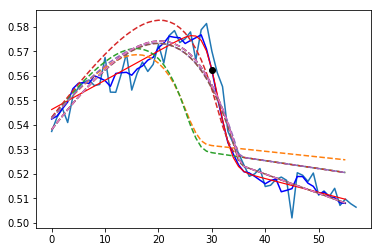

----- Stressed sample Steel 304 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 56
    # variables        = 7
    chi-square         = 4.5670e-04
    reduced chi-square = 9.3203e-06
    Akaike info crit   = -642.143327
    Bayesian info crit = -627.965865
[[Variables]]
    t0:     31.3147568 +/- 237.863256 (759.59%) (init = 34.0287)
    sigma: -0.00174044 +/- 258259.396 (14838717615.99%) (init = -0.00288285)
    alpha: -1.88935579 +/- 0.40774092 (21.58%) (init = -13.59532)
    a1:     0.51693256 +/- 0.00242424 (0.47%) (init = 0.5153808)
    a2:     4.7127e-04 +/- 6.1984e-05 (13.15%) (init = 0.001139366)
    a5:    -0.00143563 +/- 1.4147e-04 (9.85%) (init = -0.001992654)
    a6:     8.22295378 +/- 1.73536701 (21.10%) (init = 6.549694)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, sigma)    = -1.000
    C(a1, a6)       =  0.961
    C(a5, a6)  

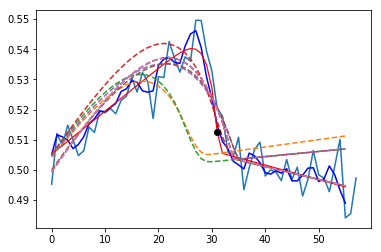

----- Stressed sample Steel 316 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 56
    # variables        = 7
    chi-square         = 4.4442e-04
    reduced chi-square = 9.0697e-06
    Akaike info crit   = -643.669593
    Bayesian info crit = -629.492132
[[Variables]]
    t0:     30.8338609 (init = 35.30678)
    sigma: -2.92205811 (init = -0.05618527)
    alpha: -0.37840264 (init = -16.15844)
    a1:     0.49972772 (init = 0.5164325)
    a2:     5.2792e-04 (init = 0.001291262)
    a5:    -5.5101e-04 (init = -0.001982131)
    a6:    -28.4121941 (init = -2.573849)



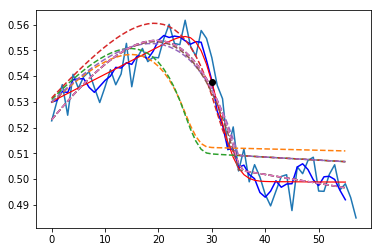

----- Stressed sample Steel 304 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 56
    # variables        = 7
    chi-square         = 5.4296e-04
    reduced chi-square = 1.1081e-05
    Akaike info crit   = -632.453806
    Bayesian info crit = -618.276344
[[Variables]]
    t0:     29.2863834 (init = 33.79952)
    sigma: -1.71874966 (init = -0.01899445)
    alpha: -0.07173749 (init = -12.91848)
    a1:     0.50292410 (init = 0.5025114)
    a2:     3.2988e-04 (init = 0.0008398161)
    a5:    -0.00141080 (init = -0.001856385)
    a6:     9.92955004 (init = 8.193402)



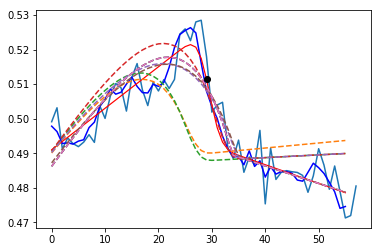

----- Stressed sample Steel 316 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 48
    # data points      = 56
    # variables        = 7
    chi-square         = 4.3691e-04
    reduced chi-square = 8.9164e-06
    Akaike info crit   = -644.624185
    Bayesian info crit = -630.446724
[[Variables]]
    t0:     31.0421422 (init = 35.80077)
    sigma: -2.69730833 (init = -0.003344402)
    alpha: -0.34310850 (init = -16.7102)
    a1:     0.47239497 (init = 0.4845101)
    a2:     3.8948e-04 (init = 0.0009943232)
    a5:    -4.8531e-04 (init = -0.0016165)
    a6:    -26.8982234 (init = -2.274814)



/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: overflow encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


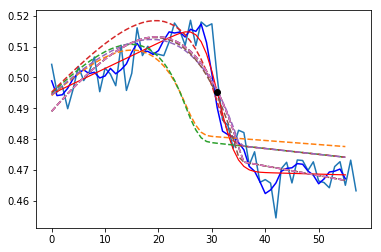

----- Stressed sample Steel 304 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 29
    # data points      = 56
    # variables        = 7
    chi-square         = 2.7853e-04
    reduced chi-square = 5.6843e-06
    Akaike info crit   = -669.834834
    Bayesian info crit = -655.657373
[[Variables]]
    t0:     27.7080777 (init = 33.86137)
    sigma: -1.98994594 (init = -0.02401406)
    alpha: -0.26442628 (init = -15.14439)
    a1:     0.45417021 (init = 0.4517624)
    a2:     2.3791e-04 (init = 0.0007193703)
    a5:    -0.00161348 (init = -0.001831168)
    a6:     14.2341442 (init = 10.45058)



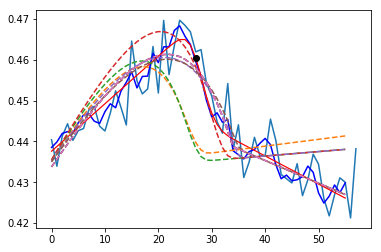

----- Stressed sample Steel 316 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 56
    # variables        = 7
    chi-square         = 5.8933e-04
    reduced chi-square = 1.2027e-05
    Akaike info crit   = -627.864591
    Bayesian info crit = -613.687129
[[Variables]]
    t0:     31.7187493 (init = 36.08713)
    sigma: -3.25458152 (init = -0.7353126)
    alpha: -0.15173707 (init = -17.36097)
    a1:     0.36071872 (init = 0.4195674)
    a2:     6.5666e-04 (init = 0.00115073)
    a5:     2.2837e-04 (init = -0.001131757)
    a6:    -85.4717052 (init = -5.035364)



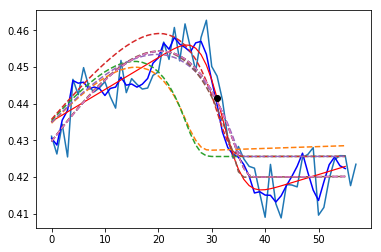

----- Stressed sample Steel 304 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 37
    # data points      = 56
    # variables        = 7
    chi-square         = 5.5522e-04
    reduced chi-square = 1.1331e-05
    Akaike info crit   = -631.204178
    Bayesian info crit = -617.026716
[[Variables]]
    t0:     29.1147932 (init = 33.68889)
    sigma: -1.04097200 (init = -0.005514652)
    alpha: -0.14303497 (init = -13.10615)
    a1:     0.42022676 (init = 0.4181139)
    a2:     4.4725e-04 (init = 0.0009389035)
    a5:    -8.8432e-04 (init = -0.001263282)
    a6:     6.39414860 (init = 4.815218)



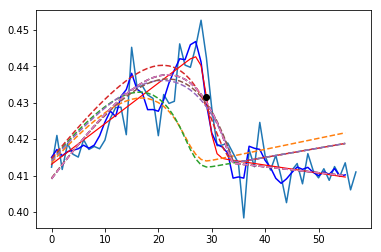

----- Stressed sample Steel 316 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 57
    # data points      = 56
    # variables        = 7
    chi-square         = 3.4962e-04
    reduced chi-square = 7.1352e-06
    Akaike info crit   = -657.104376
    Bayesian info crit = -642.926914
[[Variables]]
    t0:     31.2736569 (init = 35.63273)
    sigma: -3.33141738 (init = -1.035829)
    alpha: -0.34297250 (init = -15.77537)
    a1:     0.33645759 (init = 0.4033626)
    a2:     5.5008e-04 (init = 0.0009740246)
    a5:     2.4945e-04 (init = -0.0008971429)
    a6:    -124.383597 (init = -9.144346)



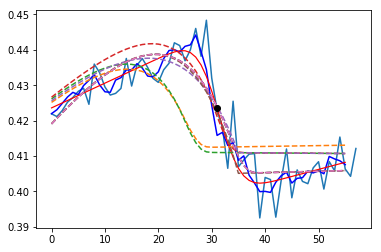

----- Stressed sample Steel 304 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 56
    # variables        = 7
    chi-square         = 3.5130e-04
    reduced chi-square = 7.1693e-06
    Akaike info crit   = -656.836888
    Bayesian info crit = -642.659426
[[Variables]]
    t0:     29.7340718 (init = 34.06424)
    sigma: -1.76715252 (init = -0.005743995)
    alpha: -0.22994022 (init = -13.76666)
    a1:     0.23952455 (init = 0.2419984)
    a2:     6.7522e-04 (init = 0.001171045)
    a5:    -3.1537e-04 (init = -0.0008779298)
    a6:    -4.67620363 (init = 0.5442837)



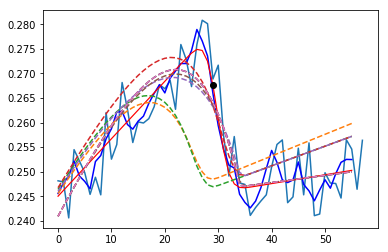

----- Stressed sample Steel 316 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 56
    # variables        = 7
    chi-square         = 4.8553e-04
    reduced chi-square = 9.9088e-06
    Akaike info crit   = -638.714716
    Bayesian info crit = -624.537254
[[Variables]]
    t0:     32.4736213 +/- 3.00842695 (9.26%) (init = 35.31714)
    sigma: -1.58797487 +/- 1.63151079 (102.74%) (init = -0.002737996)
    alpha: -2.48254782 +/- 2.64952379 (106.73%) (init = -15.87788)
    a1:     0.20080390 +/- 0.03393438 (16.90%) (init = 0.2339039)
    a2:     5.6361e-04 +/- 8.5707e-05 (15.21%) (init = 0.001064989)
    a5:     1.9526e-04 +/- 2.0212e-04 (103.52%) (init = -0.0005822871)
    a6:    -77.2488736 +/- 52.8712653 (68.44%) (init = -11.97955)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.999
    C(t0, alpha)    = -0.986
    C(t0, sigma)

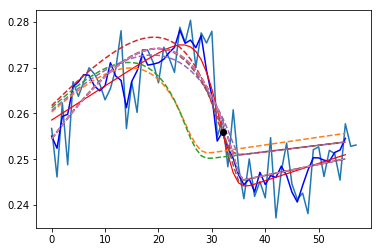

----- Stressed sample Steel 304 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 56
    # variables        = 7
    chi-square         = 4.1924e-04
    reduced chi-square = 8.5559e-06
    Akaike info crit   = -646.935428
    Bayesian info crit = -632.757966
[[Variables]]
    t0:     30.1670638 (init = 34.8514)
    sigma: -1.96963407 (init = -0.02143263)
    alpha: -0.13431811 (init = -14.39219)
    a1:     0.42075973 (init = 0.4238532)
    a2:     6.4819e-04 (init = 0.001092129)
    a5:    -2.9024e-04 (init = -0.0008249958)
    a6:    -4.82719960 (init = 0.7046578)



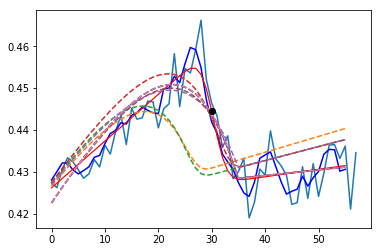

----- Stressed sample Steel 316 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 148
    # data points      = 56
    # variables        = 7
    chi-square         = 3.2254e-04
    reduced chi-square = 6.5824e-06
    Akaike info crit   = -661.619763
    Bayesian info crit = -647.442302
[[Variables]]
    t0:     32.7129201 +/- 1.70270948 (5.21%) (init = 35.33443)
    sigma: -1.22440715 +/- 0.95234869 (77.78%) (init = -0.07184177)
    alpha: -2.31166151 +/- 1.68654555 (72.96%) (init = -16.53189)
    a1:     0.43633044 +/- 0.00804578 (1.84%) (init = 0.4450574)
    a2:     3.7449e-04 +/- 6.5140e-05 (17.39%) (init = 0.0008635263)
    a5:    -2.2871e-04 +/- 1.5485e-04 (67.71%) (init = -0.0009866979)
    a6:    -27.8206195 +/- 13.3918958 (48.14%) (init = -3.742832)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.985
    C(t0, alpha)    = -0.976
    C(a1, a5)      

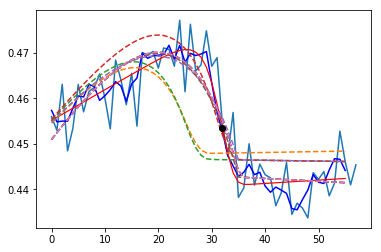

In [8]:
# I start with the position at 90 deg to see if everything works.

est_sigma=-1
est_alpha=-10


print(myrange)

print(len(stress_304))

results_stress_304 = [dict() for x in range(len(stress_304))]
results_stress_316 = [dict() for x in range(len(stress_304))]
stress304_spectrum_binned =[]
stress316_spectrum_binned =[]

for i in range(0, len(stress_304)):
    stress304_spectrum_norm=(stress_304[i][:]/ob_304[i][:])
    stress304_spectrum_binned.append(binning(stress304_spectrum_norm, 350))
    stress316_spectrum_norm=(stress_316[i][:]/ob_316[i][:])
    stress316_spectrum_binned.append(binning(stress316_spectrum_norm, 350))
    
    print('----- Stressed sample Steel 304 at position: ', i)
    
    results_stress_304[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned[i]), myrange, peak_position, est_sigma, est_alpha, False, True)
    
    print('----- Stressed sample Steel 316 at position: ', i)
    results_stress_316[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned[i]), myrange, peak_position, est_sigma, est_alpha, False, True)
    


#     results_stress1 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress1_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)
#     results_stress2 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress2_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)


[26, 34, 40]
[26, 34, 46]
[26, 33, 43]
[26, 33, 42]
[26, 33, 39]
[26, 32, 31]
[26, 33, 43]
[24, 32, 44]
[27, 31, 38]
[26, 33, 44]
[27, 34, 46]


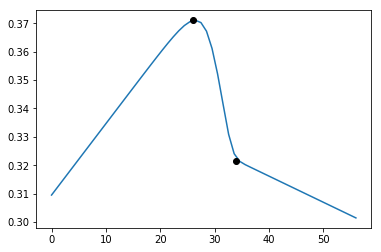

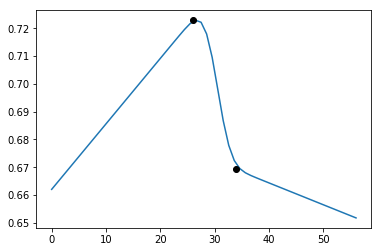

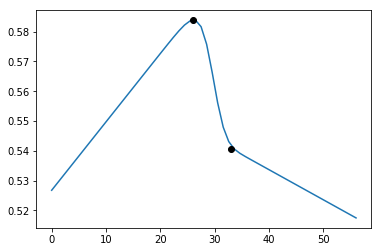

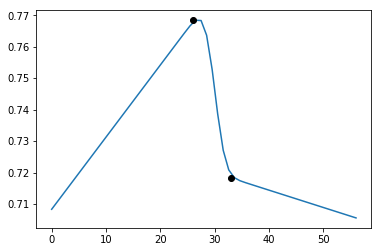

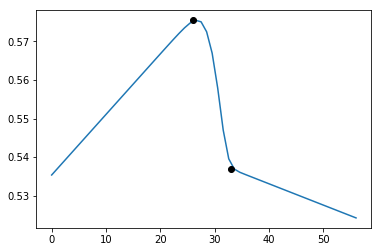

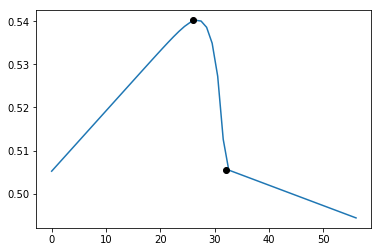

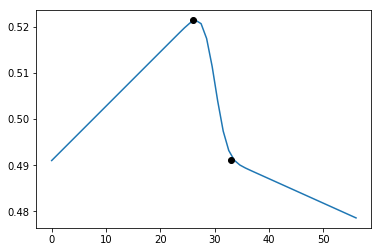

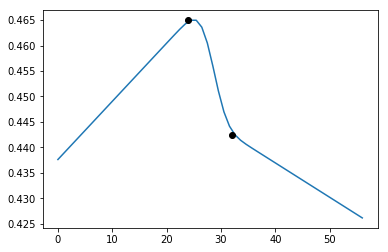

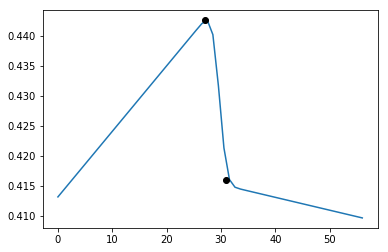

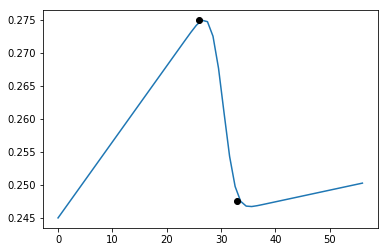

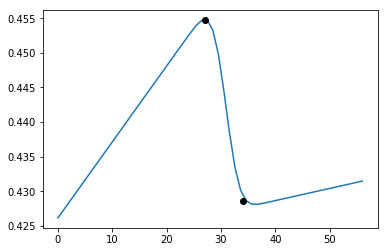

In [9]:

for i in range(0,11):
    results_s1 = results_stress_304[i]['final_result']
    fitted_data=results_stress_304[i]['fitted_data']
    a1=results_stress_304[i]['a1']
    a2=results_stress_304[i]['a2']
    a5=results_stress_304[i]['a5']
    a6=results_stress_304[i]['a6']
    t0=results_stress_304[i]['t0']
    sigma = results_stress_304[i]['sigma']
    alpha = results_stress_304[i]['alpha']
    pos_extrema = results_stress_304[i]['pos_extrema']
    print(pos_extrema)

    x=np.linspace(0,len(fitted_data), len(fitted_data))
    plt.figure()
    plt.plot(x,fitted_data)
    plt.plot(pos_extrema[0], fitted_data[pos_extrema[0]],'ok')
    plt.plot(pos_extrema[1], fitted_data[pos_extrema[1]],'ok')

[26, 38, 51]
[26, 37, 50]
[27, 34, 41]
[26, 36, 48]
[26, 36, 49]
[25, 37, 55]
[25, 37, 53]
[25, 38, 55]
[25, 38, 55]
[24, 35, 45]
[25, 35, 43]


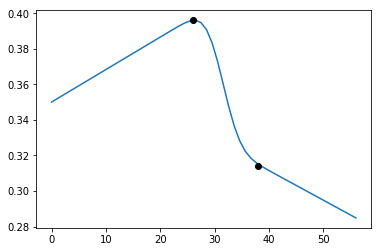

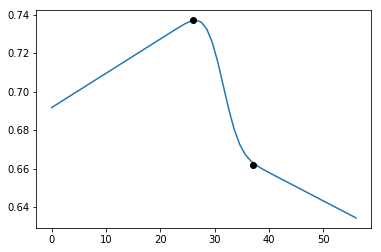

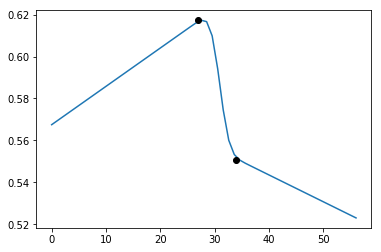

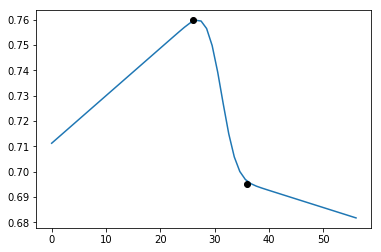

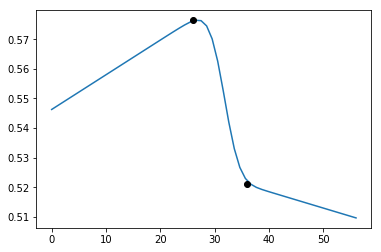

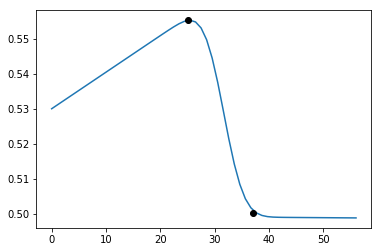

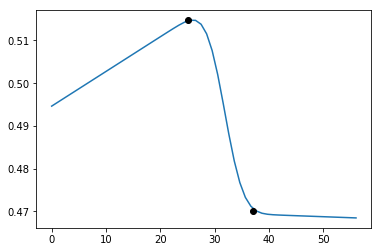

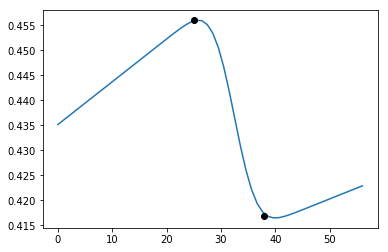

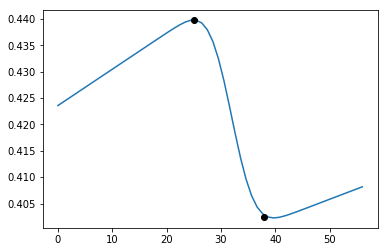

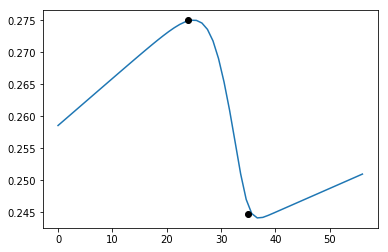

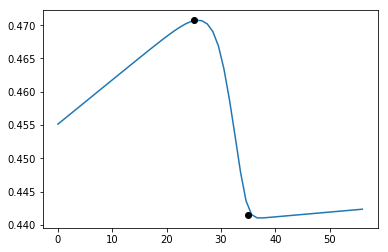

In [10]:
for i in range(0,11):
    results_s1 = results_stress_316[i]['final_result']
    fitted_data=results_stress_316[i]['fitted_data']
    a1=results_stress_316[i]['a1']
    a2=results_stress_316[i]['a2']
    a5=results_stress_316[i]['a5']
    a6=results_stress_316[i]['a6']
    t0=results_stress_316[i]['t0']
    sigma = results_stress_316[i]['sigma']
    alpha = results_stress_316[i]['alpha']
    pos_extrema = results_stress_316[i]['pos_extrema']
    print(pos_extrema)

    x=np.linspace(0,len(fitted_data), len(fitted_data))
    plt.figure()
    plt.plot(x,fitted_data)
    plt.plot(pos_extrema[0], fitted_data[pos_extrema[0]],'ok')
    plt.plot(pos_extrema[1], fitted_data[pos_extrema[1]],'ok')

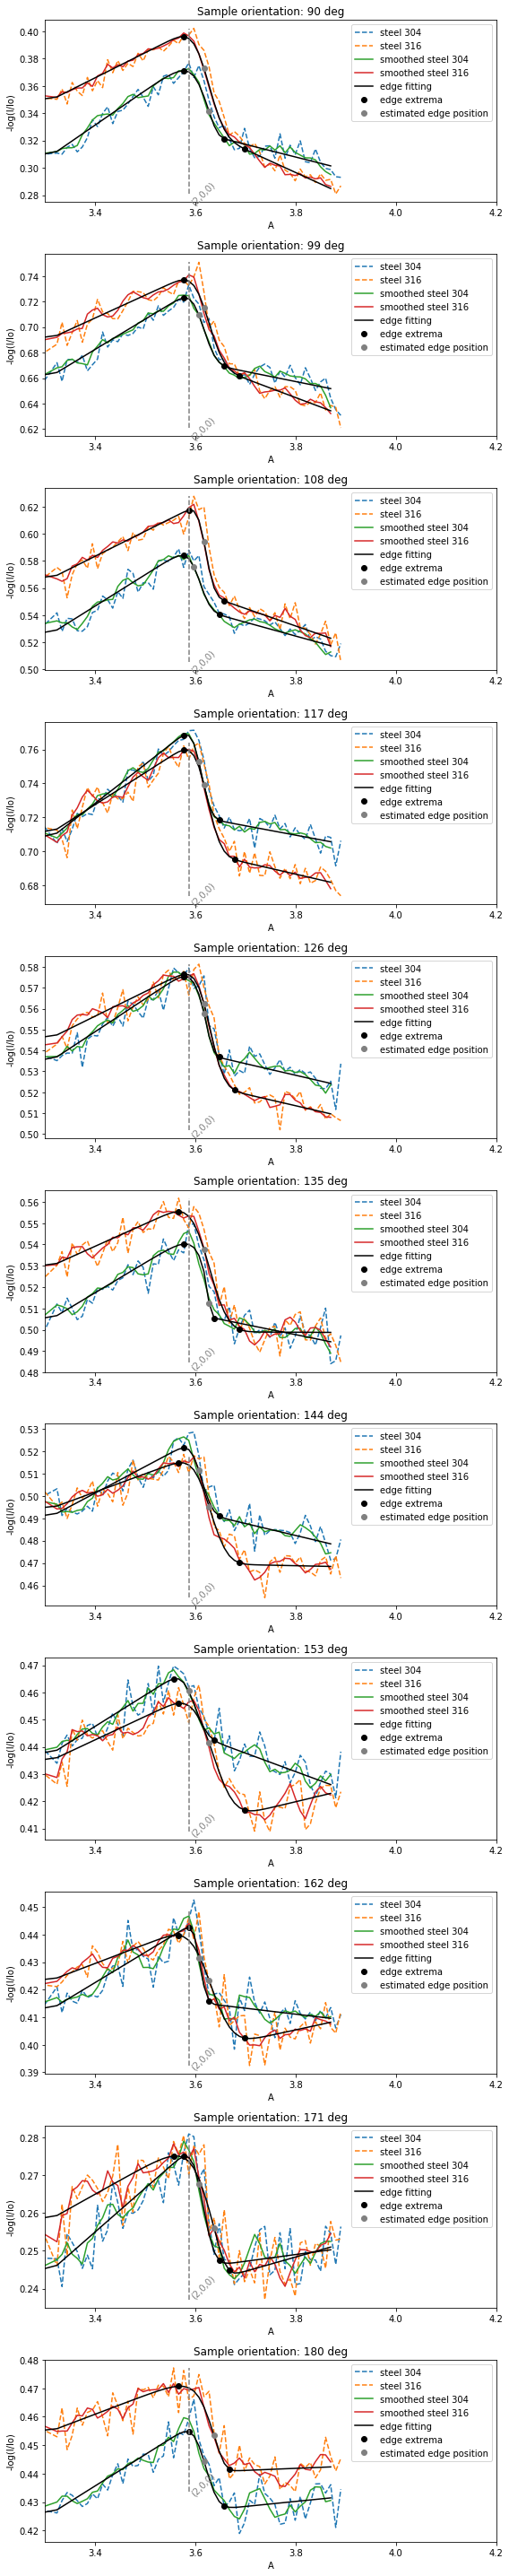

In [39]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304=[]
peak_height_316=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_stress_304)):


    results_304 = results_stress_304[i]['final_result']
    fitted_data_304=results_stress_304[i]['fitted_data']
    pos_extrema_304 = results_stress_304[i]['pos_extrema']  
    pos_peak_304 = results_stress_304[i]['t0']
    peak_height_304.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_stress_316[i]['final_result']
    fitted_data_316=results_stress_316[i]['fitted_data']
    pos_extrema_316 = results_stress_316[i]['pos_extrema']  
    pos_peak_316 = results_stress_316[i]['t0']
    peak_height_316.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])

#     print(peak_height_304, peak_height_316)

    # start with one
#     plt.figure()
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),'--', label='steel 316')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
    ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[1],2*dhkl_gammaFe[1]]), np.array([np.min(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]])), np.max(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[1]).astype(int))+','+str(k_gammaFe[1].astype(int))+','+str(l_gammaFe[1].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[1],np.min(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_200.eps', format='eps', dpi=400)

In [41]:
print(peak_height_304)
print(peak_height_316)
np.savetxt('peak_height_304_200.txt', peak_height_304)
np.savetxt('peak_height_316_200.txt', peak_height_316)

[0.049714400215197574, 0.05340379880004642, 0.043214298645789406, 0.04997821902066746, 0.038553433492794276, 0.03475747449243394, 0.03035835924789243, 0.022508410353100528, 0.026584241157718957, 0.027397217086018916, 0.026063197635320057]
[0.08225915651715998, 0.07538933048255714, 0.06674643173574957, 0.0645239302756796, 0.05538514607903078, 0.055214985301524244, 0.0446456526110971, 0.03922186476266876, 0.03731050103692718, 0.030189246562115524, 0.029178976129310308]


0.34133023464506707 0.0008117103843236297 -0.0026868431636896286 12.436723835203452
first_pos: 26
33
[26]
26 0.04290161306392504
27 0.0430230863512886
28 0.040958064212707535
29 0.03583781776711953
30 0.02781984122356501
31 0.018062939617683627
32 0.008437616752087818
33 0.0025596425600328265
34 0.0008241172592362567
34
pos_min 34
0.3213577624252971 0.32053364516606087


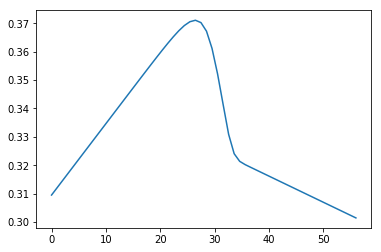

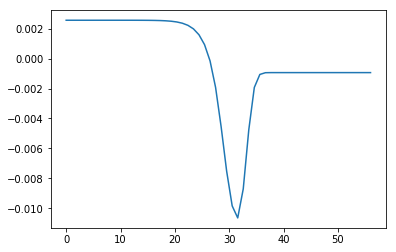

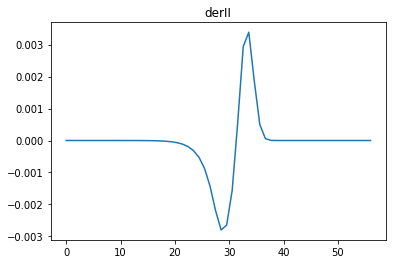

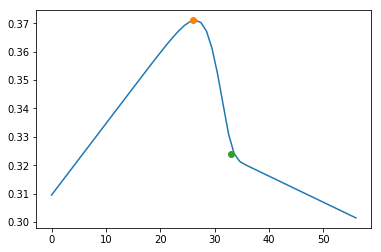

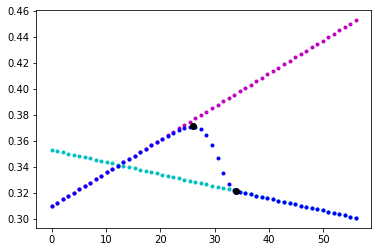

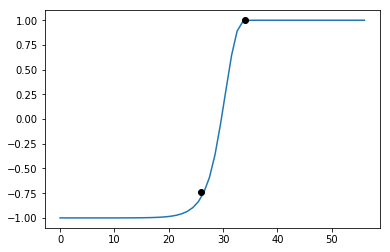

In [12]:
# Here i made some tests to check how to compute the peak height, apparently there is no definite way to do it

results_s1 = results_stress_304[0]['final_result']
fitted_data=results_s1.best_fit
a1=results_stress_304[0]['a1']
a2=results_stress_304[0]['a2']
a5=results_stress_304[0]['a5']
a6=results_stress_304[0]['a6']
t0=results_stress_304[0]['t0']
sigma = results_stress_304[0]['sigma']
alpha = results_stress_304[0]['alpha']

print(a1,a2,a5,a6)

x =np.linspace(0,len(fitted_data), len(fitted_data))
result_firstpart = AdvancedBraggEdgeFitting.ModelFirstPart(t=x,a1=a1,a2=a2,a6=a6)
result_secondpart = AdvancedBraggEdgeFitting.ModelSecondPart(t=x, a2=a2, a5=a5, a6=a6)
result_thirdpart = AdvancedBraggEdgeFitting.ModelThirdPart(t=x, t0=t0, sigma=sigma, alpha=alpha)


plt.figure()
plt.plot(x,fitted_data)

derI = np.gradient(fitted_data)
derII = np.gradient(derI)
first_pos = find_nearest(derI,0)
print('first_pos:', first_pos)
# second_pos = argrelextrema(derI, np.less)
second_pos = argrelextrema(derII, np.greater)
print(second_pos[0][1])
plt.figure()
plt.plot(x,np.gradient(fitted_data))


plt.figure()
plt.plot(x,derII)
plt.title('derII')

plt.figure()
plt.plot(x,fitted_data)
plt.plot(first_pos,fitted_data[first_pos],'o')
plt.plot(int(second_pos[0][1]),fitted_data[int(second_pos[0][1])],'o')


plt.figure()
plt.plot(x, result_firstpart-result_secondpart,'.m')  # this is the final formulation of the first line
plt.plot(x,result_firstpart+result_secondpart,'.c') # this is the final formulation of the second line... TO WRITE SOMEWHERE AND REMEMBER
plt.plot(x, result_firstpart+result_thirdpart*result_secondpart,'.b')

pos_max = argrelextrema(fitted_data, np.greater) 
# pos_min = argrelextrema(fitted_data, np.less) # this would normally work for normal peaks 

plt.plot(pos_max, fitted_data[pos_max],'ko')

pos_min=0
print(pos_max[0])
inside=True

for i in range(int(pos_max[0]), len(fitted_data)):
    print(i, np.abs(fitted_data[i]-(result_firstpart[i]+result_secondpart[i])))
    if (np.abs(fitted_data[i]-(result_firstpart[i]+result_secondpart[i]))<=0.001):
        pos_min = i
        print(pos_min)
        break


print('pos_min',pos_min)    
plt.plot(pos_min, fitted_data[pos_min],'ko')

print(fitted_data[34], result_firstpart[34]+result_secondpart[34])
plt.figure()
plt.plot(x,result_thirdpart)
plt.plot(pos_min,result_thirdpart[pos_min],'ok')
plt.plot(pos_max,result_thirdpart[pos_max],'ok')




## Here I repeat the quantitative analysis for the peak (2,2,0) happening at wavelength 2.536 

78
2.5314824536864258
60
114
[60, 114]


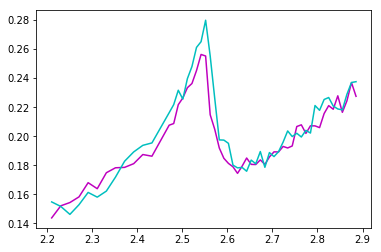

In [54]:
peak_position = find_nearest(mylambda_binned, 2.536)
print(peak_position)
print(mylambda_binned[peak_position]) # this is my position to study the peak (2,0,0)

lambda_range1 = find_nearest(mylambda_binned, 2.2)
lambda_range2 = find_nearest(mylambda_binned, 2.9)

print(lambda_range1)
print(lambda_range2)
plt.figure()
plt.plot(mylambda_binned[lambda_range1:lambda_range2], -1*np.log(stress304_spectrum_binned[0][lambda_range1:lambda_range2]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[lambda_range1:lambda_range2], -1*np.log(stress316_spectrum_binned[0][lambda_range1:lambda_range2]), label='stressed steel 316', color='c')
# plt.legend(loc='upper right')

# lambda_range = [2.2, 2.9]
myrange = [lambda_range1, lambda_range2]
# myrange = np.array([find_nearest(mylambda_binned, lambda_range[0]), find_nearest(mylambda_binned, lambda_range[1])])

print(myrange)

[60, 114]
11
----- Stressed sample Steel 304 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00191684
    reduced chi-square = 4.0784e-05
    Akaike info crit   = -539.287184
    Bayesian info crit = -525.364295
[[Variables]]
    t0:     21.7440088 (init = 26.46088)
    sigma: -1.59842617 (init = -0.01854931)
    alpha: -0.09861469 (init = -15.64439)
    a1:     0.11044379 (init = 0.1027666)
    a2:     0.00387752 (init = 0.006534838)
    a5:     1.8271e-04 (init = -0.00199164)
    a6:    -5.00504938 (init = -3.121525)



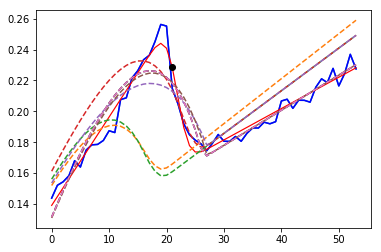

----- Stressed sample Steel 316 at position:  0
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00302453
    reduced chi-square = 6.4352e-05
    Akaike info crit   = -514.659095
    Bayesian info crit = -500.736207
[[Variables]]
    t0:     22.3953278 (init = 27.08238)
    sigma: -1.63989720 (init = -0.5340404)
    alpha: -0.17039098 (init = -15.84877)
    a1:     0.10783405 (init = 0.1013529)
    a2:     0.00446712 (init = 0.007601882)
    a5:    -7.5182e-05 (init = -0.002761459)
    a6:    -3.77198548 (init = -1.958588)



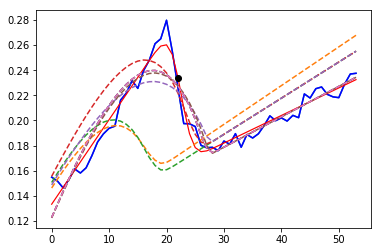

----- Stressed sample Steel 304 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 29
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00327337
    reduced chi-square = 6.9646e-05
    Akaike info crit   = -510.389691
    Bayesian info crit = -496.466803
[[Variables]]
    t0:     21.9415653 (init = 26.83762)
    sigma: -1.59239302 (init = -1.01909)
    alpha: -0.10059364 (init = -15.70085)
    a1:     0.45206453 (init = 0.4356906)
    a2:     0.00439209 (init = 0.007040247)
    a5:    -1.2968e-04 (init = -0.002147365)
    a6:     0.12646815 (init = -0.8188788)



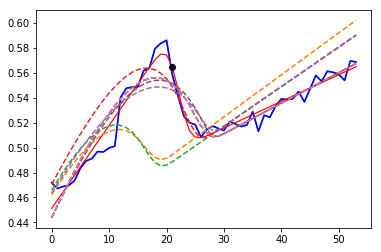

----- Stressed sample Steel 316 at position:  1
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00480144
    reduced chi-square = 1.0216e-04
    Akaike info crit   = -489.702510
    Bayesian info crit = -475.779622
[[Variables]]
    t0:     21.8648394 (init = 27.06552)
    sigma: -1.35104528 (init = -1.254074)
    alpha: -0.06647577 (init = -15.81064)
    a1:     0.46944499 (init = 0.4391834)
    a2:     0.00514753 (init = 0.008482617)
    a5:    -0.00143295 (init = -0.003634792)
    a6:     3.95774483 (init = 1.004412)



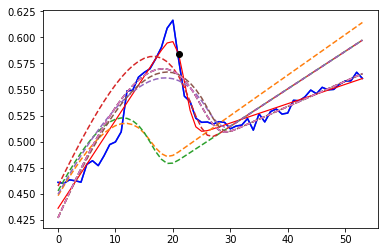

----- Stressed sample Steel 304 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00192040
    reduced chi-square = 4.0860e-05
    Akaike info crit   = -539.187167
    Bayesian info crit = -525.264279
[[Variables]]
    t0:     22.1666637 +/- 0.26989029 (1.22%) (init = 26.88484)
    sigma: -2.18942758 +/- 0.31964550 (14.60%) (init = -0.7955853)
    alpha: -0.32202029 +/- 1099944.39 (341576116.25%) (init = -16.25527)
    a1:     0.30329545 +/- 0.01467075 (4.84%) (init = 0.3106244)
    a2:     0.00359052 +/- 1.8446e-04 (5.14%) (init = 0.006072836)
    a5:     6.3302e-04 +/- 2.8228e-04 (44.59%) (init = -0.001624241)
    a6:    -10.9737369 +/- 3.41712484 (31.14%) (init = -4.85228)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.979
    C(a1, a5)    = -0.938
    C(a1, a6)    =  0.938

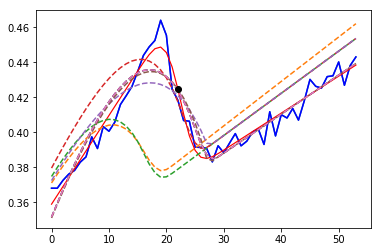

----- Stressed sample Steel 316 at position:  2
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00207003
    reduced chi-square = 4.4043e-05
    Akaike info crit   = -535.135594
    Bayesian info crit = -521.212706
[[Variables]]
    t0:     22.0542840 (init = 26.66697)
    sigma: -1.29849204 (init = -0.9939983)
    alpha: -0.07961795 (init = -15.83795)
    a1:     0.34749183 (init = 0.3354313)
    a2:     0.00398619 (init = 0.006994902)
    a5:    -1.2297e-04 (init = -0.002528812)
    a6:    -3.35971947 (init = -2.295588)



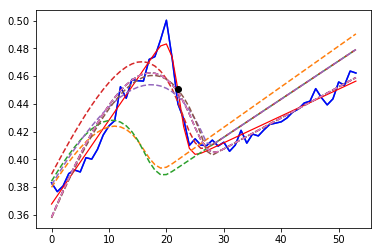

----- Stressed sample Steel 304 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00263129
    reduced chi-square = 5.5985e-05
    Akaike info crit   = -522.180255
    Bayesian info crit = -508.257367
[[Variables]]
    t0:     22.0195965 (init = 26.85132)
    sigma: -2.06320632 (init = -0.8212472)
    alpha: -0.14616414 (init = -15.96431)
    a1:     0.52113449 (init = 0.5146458)
    a2:     0.00424443 (init = 0.006704178)
    a5:     2.5904e-04 (init = -0.001838099)
    a6:    -2.61277095 (init = -1.736427)



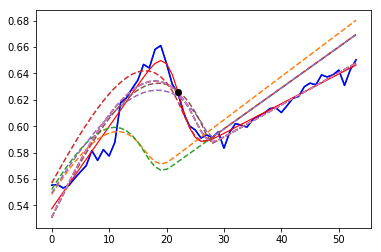

----- Stressed sample Steel 316 at position:  3
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00304443
    reduced chi-square = 6.4775e-05
    Akaike info crit   = -514.305049
    Bayesian info crit = -500.382160
[[Variables]]
    t0:     21.9066386 (init = 26.88145)
    sigma: -1.35148155 (init = -1.043087)
    alpha: -0.06936160 (init = -15.546)
    a1:     0.54102211 (init = 0.5202686)
    a2:     0.00423763 (init = 0.0069445)
    a5:    -7.8164e-04 (init = -0.00271418)
    a6:     2.43785696 (init = 0.3491497)



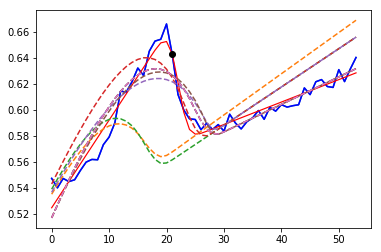

----- Stressed sample Steel 304 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00176624
    reduced chi-square = 3.7580e-05
    Akaike info crit   = -543.705759
    Bayesian info crit = -529.782871
[[Variables]]
    t0:     21.7772478 (init = 26.62967)
    sigma: -1.98038542 (init = -0.7888521)
    alpha: -0.14307309 (init = -16.0032)
    a1:     0.35947796 (init = 0.3511575)
    a2:     0.00344496 (init = 0.005633259)
    a5:     8.2780e-06 (init = -0.001783571)
    a6:    -2.64418209 (init = -2.083053)



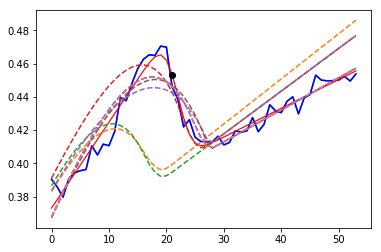

----- Stressed sample Steel 316 at position:  4
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00258829
    reduced chi-square = 5.5070e-05
    Akaike info crit   = -523.070135
    Bayesian info crit = -509.147247
[[Variables]]
    t0:     21.7046984 (init = 26.71941)
    sigma: -1.49462184 (init = -1.308419)
    alpha: -0.07849775 (init = -15.97336)
    a1:     0.37430038 (init = 0.3567103)
    a2:     0.00330097 (init = 0.00564664)
    a5:    -5.1934e-04 (init = -0.002188682)
    a6:     0.24849691 (init = -1.242429)



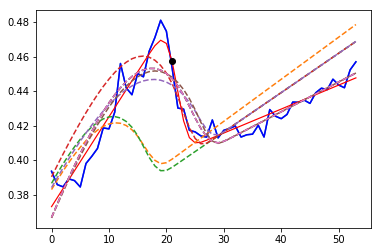

----- Stressed sample Steel 304 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00189411
    reduced chi-square = 4.0300e-05
    Akaike info crit   = -539.931480
    Bayesian info crit = -526.008592
[[Variables]]
    t0:     21.9244857 (init = 26.87441)
    sigma: -1.92253235 (init = -1.121906)
    alpha: -0.08207310 (init = -16.73715)
    a1:     0.34185625 (init = 0.3330392)
    a2:     0.00310856 (init = 0.005208633)
    a5:     7.9955e-05 (init = -0.001602885)
    a6:    -3.12908116 (init = -2.476382)



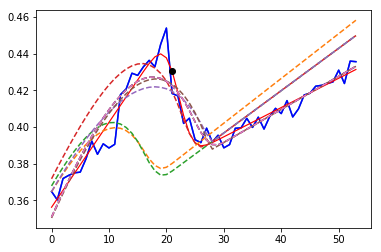

----- Stressed sample Steel 316 at position:  5
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00185417
    reduced chi-square = 3.9450e-05
    Akaike info crit   = -541.082277
    Bayesian info crit = -527.159389
[[Variables]]
    t0:     21.7438257 (init = 26.63654)
    sigma: -1.65457551 (init = -1.08519)
    alpha: -0.13110695 (init = -16.28)
    a1:     0.36513611 (init = 0.3505358)
    a2:     0.00307280 (init = 0.005314507)
    a5:    -3.8765e-04 (init = -0.00205405)
    a6:    -0.48505554 (init = -1.464493)



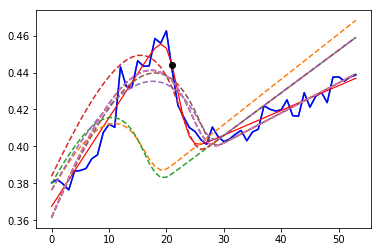

----- Stressed sample Steel 304 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00162294
    reduced chi-square = 3.4531e-05
    Akaike info crit   = -548.275073
    Bayesian info crit = -534.352184
[[Variables]]
    t0:     21.5327080 +/- 0.29265785 (1.36%) (init = 26.76955)
    sigma: -1.75151189 +/- 0.33865354 (19.33%) (init = -1.44964)
    alpha: -0.27136255 +/- 412368.923 (151962355.07%) (init = -16.67301)
    a1:     0.38157288 +/- 0.00721228 (1.89%) (init = 0.3620387)
    a2:     0.00320691 +/- 1.9617e-04 (6.12%) (init = 0.005372232)
    a5:    -4.6299e-04 +/- 2.7057e-04 (58.44%) (init = -0.001921402)
    a6:     1.77109039 +/- 1.55556593 (87.83%) (init = -0.7335773)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.953
    C(a5, a6)    = -0.871
    C(a1, a5)    = -0.778

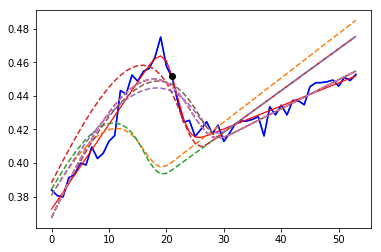

----- Stressed sample Steel 316 at position:  6
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 36
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00261748
    reduced chi-square = 5.5691e-05
    Akaike info crit   = -522.464525
    Bayesian info crit = -508.541636
[[Variables]]
    t0:     21.5543541 +/- 0.34587313 (1.60%) (init = 26.61318)
    sigma: -1.34310473 +/- 0.50499743 (37.60%) (init = -1.319395)
    alpha: -0.37960206 +/- 8.94319834 (2355.94%) (init = -15.90555)
    a1:     0.39460729 +/- 0.00709073 (1.80%) (init = 0.3732886)
    a2:     0.00305814 +/- 1.9306e-04 (6.31%) (init = 0.00521473)
    a5:    -0.00112110 +/- 3.0777e-04 (27.45%) (init = -0.002461298)
    a6:     5.35115761 +/- 1.45959169 (27.28%) (init = 1.598539)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.962
    C(a5, a6)       = -0.848
    C(a1, a5)       = -0.8

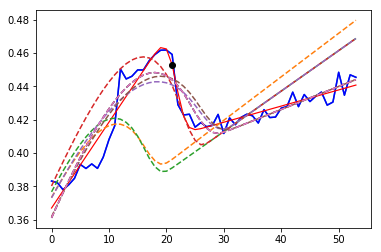

----- Stressed sample Steel 304 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00104126
    reduced chi-square = 2.2154e-05
    Akaike info crit   = -572.240848
    Bayesian info crit = -558.317959
[[Variables]]
    t0:     22.0144447 (init = 27.09671)
    sigma: -2.12931546 (init = -1.277583)
    alpha: -0.14345174 (init = -16.78766)
    a1:     0.31389556 (init = 0.3097085)
    a2:     0.00218624 (init = 0.00363344)
    a5:     1.9058e-04 (init = -0.000986973)
    a6:    -5.88372023 (init = -3.879929)



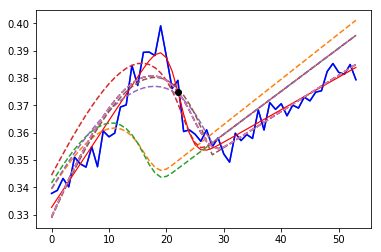

----- Stressed sample Steel 316 at position:  7
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00146562
    reduced chi-square = 3.1183e-05
    Akaike info crit   = -553.781019
    Bayesian info crit = -539.858130
[[Variables]]
    t0:     21.7139437 (init = 26.77595)
    sigma: -0.95705985 (init = -1.504256)
    alpha: -0.10005892 (init = -15.81206)
    a1:     0.32685000 (init = 0.3134164)
    a2:     0.00201846 (init = 0.003555071)
    a5:    -2.9762e-04 (init = -0.001317853)
    a6:    -0.93865900 (init = -2.445961)



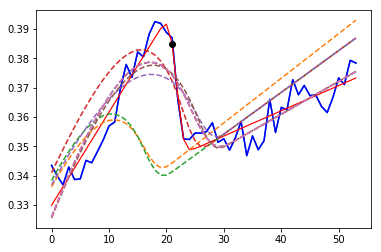

----- Stressed sample Steel 304 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00116752
    reduced chi-square = 2.4841e-05
    Akaike info crit   = -566.060325
    Bayesian info crit = -552.137436
[[Variables]]
    t0:     21.5198978 (init = 26.31471)
    sigma: -1.92235711 (init = -0.8267964)
    alpha: -0.14871137 (init = -15.31255)
    a1:     0.31121903 (init = 0.3050901)
    a2:     0.00206350 (init = 0.003344265)
    a5:    -1.0281e-04 (init = -0.001122246)
    a6:    -1.80980479 (init = -1.851608)



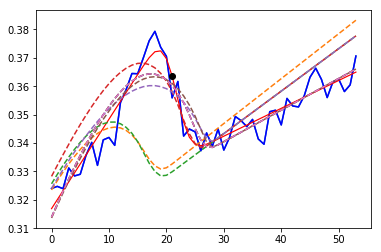

----- Stressed sample Steel 316 at position:  8
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00142823
    reduced chi-square = 3.0388e-05
    Akaike info crit   = -555.176508
    Bayesian info crit = -541.253620
[[Variables]]
    t0:     21.2344962 +/- 0.33230554 (1.56%) (init = 26.07723)
    sigma: -1.39311101 +/- 0.42147966 (30.25%) (init = -0.8575558)
    alpha: -0.22744642 +/- 89432.4304 (39320219.28%) (init = -15.29313)
    a1:     0.33578339 +/- 0.00517733 (1.54%) (init = 0.323214)
    a2:     0.00197353 +/- 1.6304e-04 (8.26%) (init = 0.003418169)
    a5:    -8.1385e-04 +/- 2.3409e-04 (28.76%) (init = -0.001766828)
    a6:     4.32174415 +/- 1.64486858 (38.06%) (init = 1.133189)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.953
    C(a5, a6)    = -0.824
    C(a1, a5)    = -0.764
 

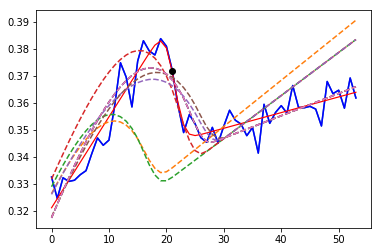

----- Stressed sample Steel 304 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 54
    # variables        = 7
    chi-square         = 8.5517e-04
    reduced chi-square = 1.8195e-05
    Akaike info crit   = -582.872298
    Bayesian info crit = -568.949410
[[Variables]]
    t0:     22.6699124 (init = 27.63195)
    sigma: -2.90870811 (init = -1.249633)
    alpha: -0.35687650 (init = -17.30691)
    a1:     0.12981145 (init = 0.1448374)
    a2:     0.00178196 (init = 0.002918936)
    a5:     6.0122e-04 (init = -0.0005435565)
    a6:    -19.6846735 (init = -7.230382)



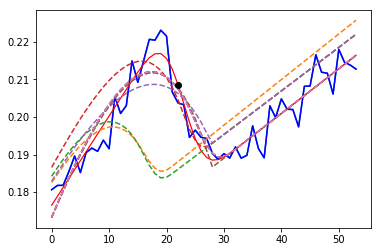

----- Stressed sample Steel 316 at position:  9
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 43
    # data points      = 54
    # variables        = 7
    chi-square         = 8.7440e-04
    reduced chi-square = 1.8604e-05
    Akaike info crit   = -581.671405
    Bayesian info crit = -567.748516
[[Variables]]
    t0:     23.1080711 +/- 2.35896116 (10.21%) (init = 26.53544)
    sigma: -0.90541273 +/- 1.26138812 (139.32%) (init = -1.033247)
    alpha: -1.42915953 +/- 2.01030050 (140.66%) (init = -16.3872)
    a1:     0.16735274 +/- 0.00664019 (3.97%) (init = 0.1621991)
    a2:     0.00170171 +/- 1.2437e-04 (7.31%) (init = 0.003161084)
    a5:    -9.9100e-05 +/- 1.9153e-04 (193.27%) (init = -0.001275329)
    a6:    -5.27445936 +/- 3.07955387 (58.39%) (init = -3.234418)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.987
    C(t0, sigma)    =  0.972
    C(a5, a6)       = -

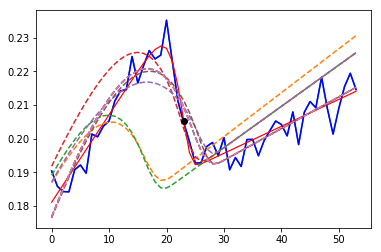

----- Stressed sample Steel 304 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 54
    # variables        = 7
    chi-square         = 9.1457e-04
    reduced chi-square = 1.9459e-05
    Akaike info crit   = -579.246293
    Bayesian info crit = -565.323405
[[Variables]]
    t0:     22.2122704 (init = 26.70086)
    sigma: -1.80870532 (init = -0.926787)
    alpha: -0.10250748 (init = -16.41132)
    a1:     0.33462547 (init = 0.3352883)
    a2:     0.00168798 (init = 0.002939945)
    a5:     2.8013e-04 (init = -0.0008044899)
    a6:    -9.12705759 (init = -4.276541)



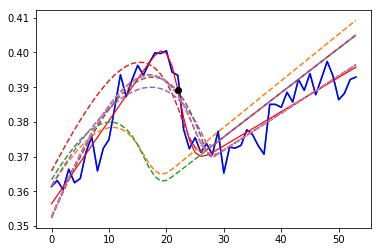

----- Stressed sample Steel 316 at position:  10
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00112509
    reduced chi-square = 2.3938e-05
    Akaike info crit   = -568.059373
    Bayesian info crit = -554.136485
[[Variables]]
    t0:     21.6675768 (init = 26.79743)
    sigma: -0.95198098 (init = -0.8947656)
    alpha: -0.07725433 (init = -16.78142)
    a1:     0.37853099 (init = 0.3664844)
    a2:     0.00162152 (init = 0.003055492)
    a5:    -4.9763e-04 (init = -0.001457799)
    a6:     1.10989435 (init = -1.152911)



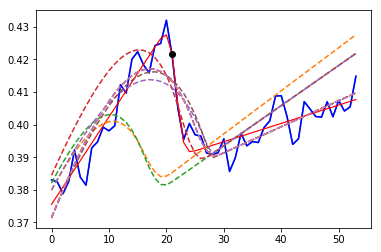

In [56]:

est_sigma=-1
est_alpha=-10


print(myrange)

print(len(stress_304))

results_stress_304_220 = [dict() for x in range(len(stress_304))]
results_stress_316_220 = [dict() for x in range(len(stress_304))]
stress304_spectrum_binned =[]
stress316_spectrum_binned =[]

for i in range(0, len(stress_304)):
    stress304_spectrum_norm=(stress_304[i][:]/ob_304[i][:])
    stress304_spectrum_binned.append(binning(stress304_spectrum_norm, 350))
    stress316_spectrum_norm=(stress_316[i][:]/ob_316[i][:])
    stress316_spectrum_binned.append(binning(stress316_spectrum_norm, 350))
    
    print('----- Stressed sample Steel 304 at position: ', i)
    
    results_stress_304_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned[i]), myrange, peak_position, est_sigma, est_alpha, False, False)
    
    print('----- Stressed sample Steel 316 at position: ', i)
    results_stress_316_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned[i]), myrange, peak_position, est_sigma, est_alpha, False, False)
    


#     results_stress1 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress1_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)
#     results_stress2 = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress2_spectrum_binned), myrange, peak_position, est_sigma, est_alpha, False)


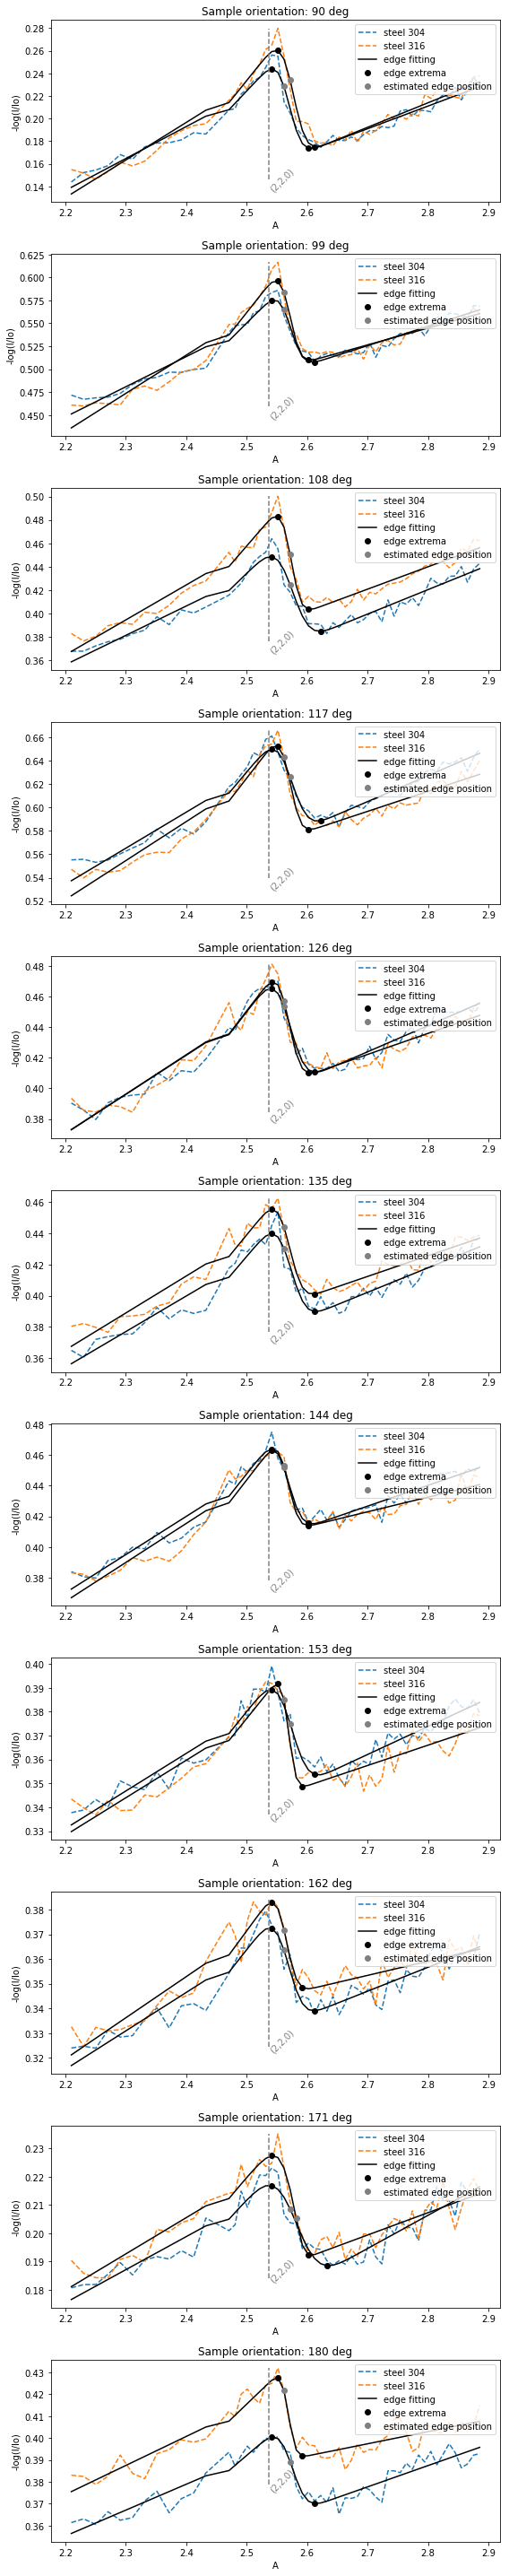

In [64]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304=[]
peak_height_316=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_stress_304_220)):


    results_304 = results_stress_304_220[i]['final_result']
    fitted_data_304=results_stress_304_220[i]['fitted_data']
    pos_extrema_304 = results_stress_304_220[i]['pos_extrema']  
    pos_peak_304 = results_stress_304_220[i]['t0']
    peak_height_304.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_stress_316_220[i]['final_result']
    fitted_data_316=results_stress_316_220[i]['fitted_data']
    pos_extrema_316 = results_stress_316_220[i]['pos_extrema']  
    pos_peak_316 = results_stress_316_220[i]['t0']
    peak_height_316.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])

#     print(peak_height_304, peak_height_316)

    # start with one
#     plt.figure()
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
#     ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[2],2*dhkl_gammaFe[2]]), np.array([np.min(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]])), np.max(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[2]).astype(int))+','+str(k_gammaFe[2].astype(int))+','+str(l_gammaFe[2].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[2],np.min(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_220.eps', format='eps', dpi=400)

In [65]:
np.savetxt('peak_height_304_220.txt', peak_height_304)
np.savetxt('peak_height_316_220.txt', peak_height_316)